# Tute 1 - Filtering data and Regularised Regression

Go through the tute with Python

In [1]:
# unlike MATLAB, core Python is limited to a few data types and built in methods
# Thats ok though, because there is a tonne of open source packages that do
# pretty much everything we need, we just need to import them

# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes (exactly the same as tables in Matlab)
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

First step is to combine all of the data from the spreadsheets. Want to combine temperature, rainfall and solar data from the same date and have them all on the same row entry.
Looking at one of the data sets, we see that the year, month and day are separated across different columns.
Want to have a single column to allow us to compare dates. This function can be applied to each
row in a dataframe using the built-in `apply()` method.

In [2]:
# Create single datetime object from year, month and day
def create_date(row):
    # create string with date it format Y:m:d
  return datetime.strptime('{}/{}/{}'.format(row.Year, row.Month, row.Day),
                           '%Y/%m/%d')

In [3]:
# Q1. Load in all the data
def load_bom(root_dir='/home/ethan/cab420/tutes/CAB420_Tutorial1/BOM'):
  """load in the BOM data and concatenate it all"""
  rain = pd.read_csv(os.path.join(root_dir, 'IDCJAC0009_040913_1800_Data.csv'))
  temp = pd.read_csv(os.path.join(root_dir, 'IDCJAC0010_040913_1800_Data.csv'))
  solar = pd.read_csv(os.path.join(root_dir, 'IDCJAC0016_040913_1800_Data.csv'))
  
  # want all the date ranges to be the same
  rain = rain[(rain.Year >= 2014) & (rain.Year <= 2018)]
  temp = temp[(temp.Year >= 2014) & (temp.Year <= 2018)]
  solar = solar[(solar.Year >= 2014) & (solar.Year <= 2018)]
  # create a datetime object for each row, and store it in the Date column
  rain['Date'] = rain.apply(create_date, axis=1)
  temp['Date'] = temp.apply(create_date, axis=1)
  solar['Date'] = solar.apply(create_date, axis=1)
  # now merge them all based on the date, so will create a single Date
  # column that has them all in
  bom_combined = pd.merge(rain, temp, on='Date')
  bom_combined = pd.merge(bom_combined, solar, on='Date')
  return bom_combined



In [4]:
# load it in, and then lets have a look at it to make sure it is all ok
bom = load_bom()
print(bom.head())

  Product code_x  Bureau of Meteorology station number_x  Year_x  Month_x  \
0     IDCJAC0009                                   40913    2014        1   
1     IDCJAC0009                                   40913    2014        1   
2     IDCJAC0009                                   40913    2014        1   
3     IDCJAC0009                                   40913    2014        1   
4     IDCJAC0009                                   40913    2014        1   

   Day_x  Rainfall amount (millimetres)  \
0      1                            0.0   
1      2                            0.0   
2      3                            1.0   
3      4                            0.0   
4      5                            0.0   

   Period over which rainfall was measured (days) Quality_x       Date  \
0                                             1.0         N 2014-01-01   
1                                             1.0         N 2014-01-02   
2                                             1.0       

In [5]:
# looks like there are some repeated columns (from the year/month/day)
#lets get rid of those
print(bom.columns.values)

['Product code_x' 'Bureau of Meteorology station number_x' 'Year_x'
 'Month_x' 'Day_x' 'Rainfall amount (millimetres)'
 'Period over which rainfall was measured (days)' 'Quality_x' 'Date'
 'Product code_y' 'Bureau of Meteorology station number_y' 'Year_y'
 'Month_y' 'Day_y' 'Maximum temperature (Degree C)'
 'Days of accumulation of maximum temperature' 'Quality_y' 'Product code'
 'Bureau of Meteorology station number' 'Year' 'Month' 'Day'
 'Daily global solar exposure (MJ/m*m)']


In [6]:
bom = bom.drop(['Year', 'Month', 'Day',
                'Year_x', 'Month_x', 'Day_x',
                'Year_y', 'Month_y', 'Day_y'], axis=1)
bom.head()

,Product code_x,Bureau of Meteorology station number_x,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality_x,Date,Product code_y,Bureau of Meteorology station number_y,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality_y,Product code,Bureau of Meteorology station number,Daily global solar exposure (MJ/m*m)
0,IDCJAC0009,40913,0.0,1.0,N,2014-01-01,IDCJAC0010,40913,30.6,1.0,Y,IDCJAC0016,40913,31.2
1,IDCJAC0009,40913,0.0,1.0,N,2014-01-02,IDCJAC0010,40913,31.8,1.0,Y,IDCJAC0016,40913,23.4
2,IDCJAC0009,40913,1.0,1.0,N,2014-01-03,IDCJAC0010,40913,34.5,1.0,Y,IDCJAC0016,40913,29.6
3,IDCJAC0009,40913,0.0,1.0,N,2014-01-04,IDCJAC0010,40913,38.7,1.0,Y,IDCJAC0016,40913,30.5
4,IDCJAC0009,40913,0.0,1.0,N,2014-01-05,IDCJAC0010,40913,33.6,1.0,Y,IDCJAC0016,40913,15.7


In [7]:
# now want to load in the BCC data and see which columns are available in all of
# the different data sets
def load_bcc(root_dir='/home/ethan/cab420/tutes/CAB420_Tutorial1/BCCCyclewayCounts'):
  """load in the BCC dataset and combine them"""
  bcc_2014 = pd.read_csv(os.path.join(root_dir, 'bike-ped-auto-counts-2014.csv'))
  bcc_2015 = pd.read_csv(os.path.join(root_dir, 'bike-ped-auto-counts-2015.csv'))
  bcc_2016 = pd.read_csv(os.path.join(root_dir, 'bike-ped-auto-counts-2016.csv'))
  bcc_2017 = pd.read_csv(os.path.join(root_dir, 'bike-ped-auto-counts-2017.csv'))
  bcc_2018 = pd.read_csv(os.path.join(root_dir, 'bike-ped-auto-counts-2018.csv'))

  # lets get the column values, and see which are consistent across them all
  # itertools is a helper module to help us convert the list of dataframe column
  # values (a list of lists) to one big flattened out list.
  # This flattened lists could have repeated entries
  all_columns_repeated = list(itertools.chain(*(
    bcc_2014.columns.values, bcc_2015.columns.values,
    bcc_2016.columns.values, bcc_2017.columns.values,
    bcc_2018.columns.values)))
  # creating a set of these column values  will remove duplicates
  all_columns = set(all_columns_repeated)
  # now lets perform the intersection of this set with each set of the column
  # values from each data set.
  # this will tell us which columns are common to every data set
  common_column = all_columns.intersection(bcc_2014.columns.values, bcc_2015.columns.values,
                                           bcc_2016.columns.values, bcc_2017.columns.values,
                                           bcc_2018.columns.values)
  # now lets get just the common columns from each data frame, and then
  # concatenate them all
  bcc_2014 = bcc_2014[common_column]
  bcc_2015 = bcc_2015[common_column]
  bcc_2016 = bcc_2016[common_column]
  bcc_2017 = bcc_2017[common_column]
  bcc_2018 = bcc_2018[common_column]
  # now concatenate them all (concat vertically)
  bcc = pd.concat([bcc_2014, bcc_2015, bcc_2016,
                   bcc_2017, bcc_2018])
  return bcc


In [8]:
bcc = load_bcc()
bcc.head()

,Riverwalk Cyclists Outbound,Story Bridge West Pedestrian Inbound,Kedron Brook Bikeway Mitchelton,Kedron Brook Bikeway Lutwyche Pedestrians Outbound,Story Bridge East Cyclists Inbound,Bishop Street Pedestrians Inbound,Jack Pesch Bridge Pedestrians Inbound,Granville Street Bridge Pedestrians Inbound,Bicentennial Bikeway Cyclists Inbound,Ekibin Park Cyclists Outbound,...,Date,Kedron Brook Bikeway Mitchelton Pedestrian Outbound,Ekibin Park Cyclists Inbound,Riverwalk Pedestrians Inbound,Riverwalk Pedestrians Outbound,Story Bridge East Pedestrian Inbound,Bicentennial Bikeway Pedestrians Outbound,Story Bridge West Pedestrian Outbound,North Brisbane Bikeway Mann Park Windsor Pedestrian Outbound,Kedron Brook Bikeway Lutwyche
0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,569.0,NaN,...,1/01/2014,NaN,NaN,NaN,NaN,0.0,1326.0,0.0,NaN,NaN
1,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,658.0,NaN,...,2/01/2014,NaN,NaN,NaN,NaN,0.0,2133.0,0.0,NaN,NaN
2,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,463.0,NaN,...,3/01/2014,NaN,NaN,NaN,NaN,0.0,1867.0,0.0,NaN,NaN
3,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,410.0,NaN,...,4/01/2014,NaN,NaN,NaN,NaN,0.0,1522.0,0.0,NaN,NaN
4,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,654.0,NaN,...,5/01/2014,NaN,NaN,NaN,NaN,0.0,2102.0,0.0,NaN,NaN


In [9]:
# now we can combine (merge) both the BOM and BCC dataframe
# again, want to merge using the date to make sure eveything is aligned and
# organised properly
# First, want to convert the Date column to a format consistent with the BOM data
bcc.Date = pd.to_datetime(bcc.Date)
combined = pd.merge(bom, bcc, on='Date')

In [10]:
print(combined.head())

  Product code_x  Bureau of Meteorology station number_x  \
0     IDCJAC0009                                   40913   
1     IDCJAC0009                                   40913   
2     IDCJAC0009                                   40913   
3     IDCJAC0009                                   40913   
4     IDCJAC0009                                   40913   

   Rainfall amount (millimetres)  \
0                            0.0   
1                            0.0   
2                            1.0   
3                            0.0   
4                            0.0   

   Period over which rainfall was measured (days) Quality_x       Date  \
0                                             1.0         N 2014-01-01   
1                                             1.0         N 2014-01-02   
2                                             1.0         N 2014-01-03   
3                                             1.0         N 2014-01-04   
4                                             1.0   

# Q2 - Regularised Regression

In [11]:
# want to find samples that have a small amount of data, as we want to initially
# use as many samples as possible
# will remove some columns that, we don't actually need (aren't covariates)
# such as the BOM station number, etc.
to_drop = ['Product code_x', 'Bureau of Meteorology station number_x',
           'Product code_y', 'Bureau of Meteorology station number_y',
           'Product code', 'Bureau of Meteorology station number',
           'Period over which rainfall was measured (days)',
           'Days of accumulation of maximum temperature',
           'Quality_x', 'Quality_y']
#print(combined.columns.values)
combined = combined.drop(to_drop, axis=1)


In [12]:
# now find columns/features/covariates that have a suitable amount of data,
# lets say 300 first
threshold = 300
columns_to_remove = []
for column in combined.columns.values:
  if np.sum(pd.isna(combined[column])) > 300:
    # add this column to the list that should be removed
    columns_to_remove.append(column)
print(columns_to_remove)
# now lets remove them
combined = combined.drop(columns_to_remove, axis=1)

['Riverwalk Cyclists Outbound', 'Kedron Brook Bikeway Mitchelton', 'Kedron Brook Bikeway Lutwyche Pedestrians Outbound', 'Bishop Street Pedestrians Inbound', 'Jack Pesch Bridge Pedestrians Inbound', 'Granville Street Bridge Pedestrians Inbound', 'Ekibin Park Cyclists Outbound', 'Jack Pesch Bridge Cyclists Inbound', 'Story Bridge West Cyclists Outbound', 'Kedron Brook Bikeway Mitchelton Cyclist Outbound', 'Bishop Street Cyclists Outbound', 'Bishop Street Cyclists Inbound', 'Kedron Brook Bikeway Lutwyche Pedestrians Inbound', 'Kedron Brook Bikeway Mitchelton Cyclist Inbound', 'Ekibin Park Pedestrians Inbound', 'Jack Pesch Bridge Cyclists Outbound', 'Granville Street Bridge Pedestrians Outbound', 'Bishop Street Pedestrians Outbound', 'Granville Street Bridge Cyclists Inbound', 'Riverwalk Cyclists Inbound', 'Jack Pesch Bridge Pedestrians Outbound', 'Granville Street Bridge Cyclists Outbound', 'Kedron Brook Bikeway Lutwyche Cyclists Inbound', 'Ekibin Park Pedestrians Outbound', 'Kedron Broo

In [13]:
# now drop any rows that contain a Nan, and get rid of them
combined_filtered = combined.dropna(axis=0)
# lets have a look at the final data set
print(combined_filtered.head())
print('Final dataset shape = {}'.format(combined_filtered.shape))

    Rainfall amount (millimetres)       Date  Maximum temperature (Degree C)  \
6                            40.2 2014-01-07                            31.2   
7                             0.4 2014-01-08                            29.6   
8                             0.2 2014-01-09                            28.6   
9                             1.4 2014-01-10                            27.8   
10                            0.0 2014-01-11                            29.8   

    Daily global solar exposure (MJ/m*m)  \
6                                   27.2   
7                                   22.1   
8                                   19.8   
9                                   14.0   
10                                  22.6   

    Story Bridge West Pedestrian Inbound  Story Bridge East Cyclists Inbound  \
6                                    0.0                                 0.0   
7                                    1.0                                 0.0   
8             

In [14]:
# split into train/test split
train = combined_filtered[combined_filtered.Date < datetime(year=2017, month=1, day=1)]
val = combined_filtered[((combined_filtered.Date >= datetime(year=2017, month=1, day=1)) &
                        (combined_filtered.Date < datetime(year=2018, month=1, day=1)))]
test = combined_filtered[((combined_filtered.Date >= datetime(year=2018, month=1, day=1)) &
                          (combined_filtered.Date < datetime(year=2019, month=1, day=1)))]
print('num train = {}'.format(train.shape[0]))
print('val train = {}'.format(val.shape[0]))
print('test train = {}'.format(test.shape[0]))

num train = 888
val train = 277
test train = 261


['Rainfall amount (millimetres)', 'Daily global solar exposure (MJ/m*m)', 'Maximum temperature (Degree C)', 'Story Bridge East Cyclists Inbound', 'Story Bridge West Cyclists Inbound', 'North Brisbane Bikeway Mann Park Windsor Cyclists Inbound', 'Schulz Canal Bridge Cyclists Inbound']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     101.8
Date:                Mon, 02 Mar 2020   Prob (F-statistic):          7.02e-109
Time:                        09:34:02   Log-Likelihood:                -6923.2
No. Observations:                 888   AIC:                         1.386e+04
Df Residuals:                     880   BIC:                         1.390e+04
Df Model:                           7                                         
Cova

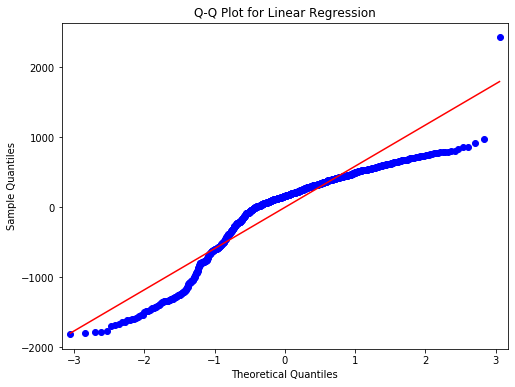

In [15]:
# now perform linear regression using Ordinary Least Squares
# want to use all weather data from the BOM
X_bom = ['Rainfall amount (millimetres)',
         'Daily global solar exposure (MJ/m*m)',
         'Maximum temperature (Degree C)']
# want to use all variables cyclist inbound variables
X_bcc = [x for x in train.columns.values if 'Cyclists Inbound' in x]
# remove the response variable from here
X_bcc.remove('Bicentennial Bikeway Cyclists Inbound')
# combine this list of variables together by just extending the
# BOM data with the BCC data
X_variables = X_bom + X_bcc
print(X_variables)
Y_train = np.array(
  train['Bicentennial Bikeway Cyclists Inbound'], dtype=np.float64)
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# create the linear model
model = sm.OLS(Y_train, X_train)

# fit the model without any regularisation
unreg = model.fit()
print(unreg.summary())
print(unreg.params)

fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(unreg.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression')
plt.show()

In [16]:
# fit the model with L2 regularisation (Ridge Regression)
unreg = model.fit_regularized()